### Bible Reading Progress Tracker - Data Exploration

Notebook ini digunakan untuk:
1. Load dan parse WhatsApp chat data
2. Analisis statistik dasar
3. Visualisasi pola komunikasi
4. Identifikasi pattern untuk progress reports

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import sys

# suppress warnings in notebook
warnings.filterwarnings('ignore')

# always absolute path
sys.path.append(str(Path('../').resolve()))

from src.preprocessing.parsing.whatsapp_parser import WhatsAppParser
from src.preprocessing.message_filter import MessageFilter
from annotation.bible_reference_annotator import BibleReferenceAnnotator

# set style for plots
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

#### 1. Load Data

In [2]:
# Load Whatsapp chat data
parser = WhatsAppParser()
filter = MessageFilter()

CHAT_FILE = Path('../data/raw/whatsapp_exports/_chat.txt')

df = parser.parse_chat_file(CHAT_FILE)
print(f'Total messages parsed: {len(df)}')
print(f'\nDataFrame shape: {df.shape}')
print(f'\nColumns: {df.columns.tolist()}')


Total messages parsed: 19142

DataFrame shape: (19142, 3)

Columns: ['timestamp', 'sender', 'message']


In [3]:
# Filter system-like messages
df_filtered = filter.filter_system_messages(df)
print(f'Total messages after filtering system messages: {len(df_filtered)}')

Total messages after filtering system messages: 18680


In [4]:
df_filtered = filter.filter_non_text_messages(df_filtered)
print(f'Total messages after filtering non-text messages: {len(df_filtered)}')

Total messages after filtering non-text messages: 18524


In [5]:
# Filter short and long messages (3 < text < 400)
df_clean = filter.filter_messages_by_length(df_filtered, 3, 300)
print(f'Total messages after filtering long messages: {len(df_clean)}')

Total messages after filtering long messages: 17191


In [6]:
# Display filtered messages
df_clean.head(15)

,timestamp,sender,message
0,2020-08-02 11:52:41,"dr. Andreas C.N., Fp.B.",Siap terimakasih sudah diadd di grup 🙏🏻
1,2020-08-02 11:52:51,Lenny Pandjidharma,sami2 ...
2,2020-08-02 11:53:17,Lenny Pandjidharma,untuk peraturan group dan tata pelaksanaan ......
3,2020-08-02 12:20:41,Oma Lisa,Thanks Lenny.t Lisa ikut ya spytdk cpt pikun a...
4,2020-08-02 12:22:35,Mfitri,"Ok,makasih ci 🙏"
5,2020-08-02 12:51:17,Sim Ay Tjan,Thanks Len.🙏🏼
6,2020-08-02 13:01:32,Tjunfebelyana,Thanks Len🙏
7,2020-08-02 14:22:31,Oma Lisa,Mulak kapan dan jam brp Lenny.Gbu txs
8,2020-08-02 14:26:58,Lenny Pandjidharma,"Dimulainya besok, Tante Lisa."
10,2020-08-02 15:03:11,🎍,"Baik, tks. Gbu🙏"


In [7]:
# filtered out messages
df_long = df_filtered.loc[~df_filtered.index.isin(df_clean.index)]
print(f'Number of messages that are too short or too long: {len(df_long)}')

Number of messages that are too short or too long: 1333


In [8]:
# Display inverse filtered messages
df_long.head(15)

,timestamp,sender,message
9,2020-08-02 14:37:45,Oma Lisa,Ok
12,2020-08-02 20:18:29,Vik. Dessy Waiman,*Introduksi Kitab Kejadian*\n\n*Judul*\n\nTuha...
15,2020-08-02 20:24:24,Vik. Dessy Waiman,"Selamat malam bpk, ibu, sdr, sdri,\nSelamat be..."
17,2020-08-02 20:36:10,Vik. Dessy Waiman,"**Bible Reading Cycle 2, 3 Agst 2020**\n\n*📖 G..."
21,2020-08-02 21:52:10,Vik. Dessy Waiman,"Selamat malam bpk, ibu, sdr, sdri,\nSelamat be..."
22,2020-08-02 21:53:03,Vik. Dessy Waiman,*Introduksi Kitab Kejadian*\n\n*Judul*\n\nTuha...
23,2020-08-02 21:57:05,Vik. Dessy Waiman,"**Bible Reading Cycle 2, 3 Agst 2020**\n\n*📖 G..."
49,2020-08-03 13:28:03,Oma Lisa,"**Bible Reading Cycle 2, 3 Agst 2020**\n\n*📖 G..."
67,2020-08-04 00:18:15,Vik. Dessy Waiman,*Update BRC2*\n\n📖 *Kej 1-2* 📖\n\n1. Agnes 💥\n...
68,2020-08-04 00:23:16,Vik. Dessy Waiman,"**Bible Reading Cycle 2, Selasa, 4 Agst 2020**..."


In [9]:
df_long.to_csv(Path('../data/processed/filtered_out_messages.csv'), index=False)

In [9]:
# saved the dataset
df_clean.to_csv('..\data\processed\cleaned_messages.csv', index=False, encoding="utf-8-sig")

#### 2. Basic Statistics

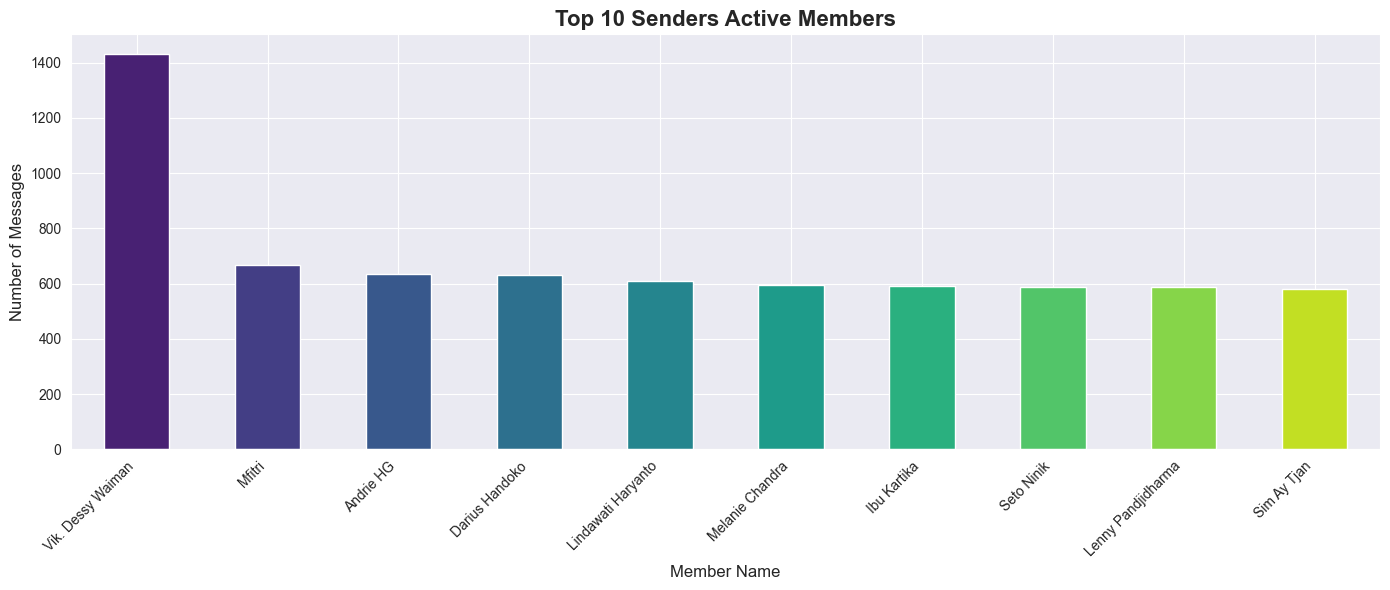

In [10]:
# Message counts by sender
sender_counts = df_filtered['sender'].value_counts()

# Top 10 active members
sender_counts.head(10).plot(kind='bar', color=sns.color_palette('viridis', 10))
plt.title('Top 10 Senders Active Members', fontsize=16, fontweight='bold')
plt.xlabel('Member Name', fontsize=12)
plt.ylabel('Number of Messages', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [11]:
# Messages per day
messages_per_day = df_filtered.groupby(df_filtered['timestamp'].dt.date).size()

print(f'\nMessages per day statistics:')
print(f'Mean: {messages_per_day.mean():.2f}')
print(f'Median: {messages_per_day.median():.2f}')
print(f'Max: {messages_per_day.max()}')
print(f'Min: {messages_per_day.min()}')


Messages per day statistics:
Mean: 26.73
Median: 27.00
Max: 81
Min: 1


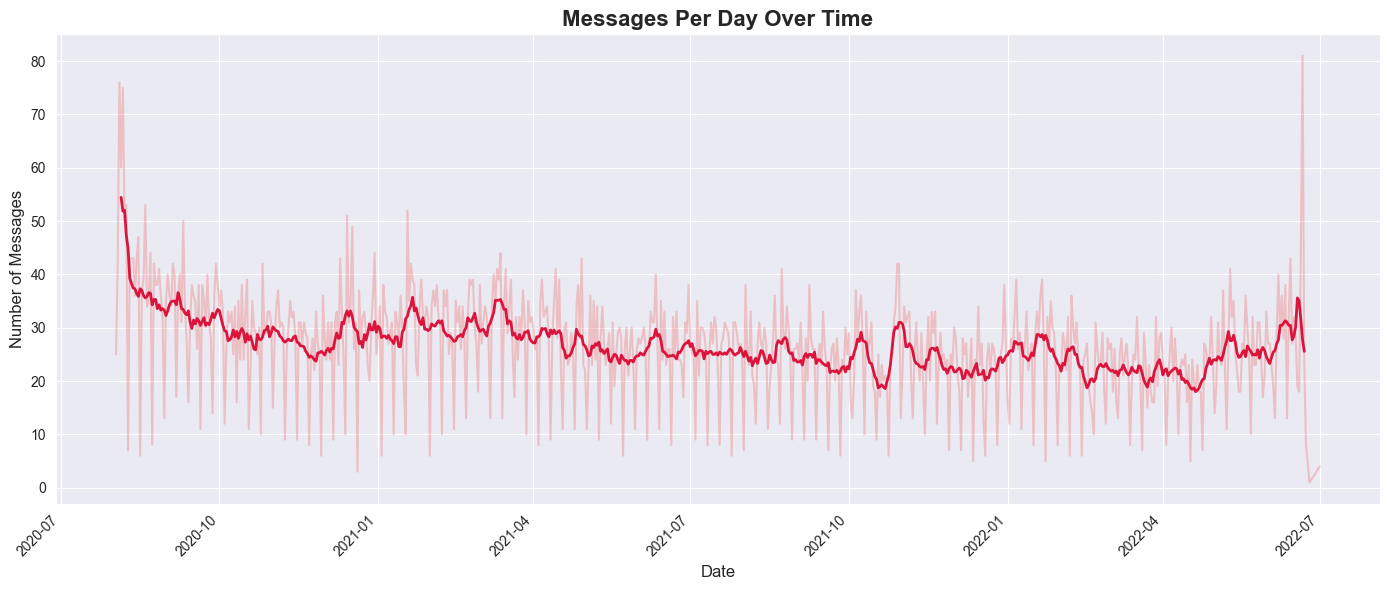

In [12]:
rolling = messages_per_day.rolling(window=7, center=True).mean()
plt.plot(messages_per_day.index, messages_per_day.values, color='lightcoral', alpha=0.4, label='Daily')
plt.plot(rolling.index, rolling.values, color='crimson', linewidth=2, label='7-Day Rolling Average')
plt.title('Messages Per Day Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Messages', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

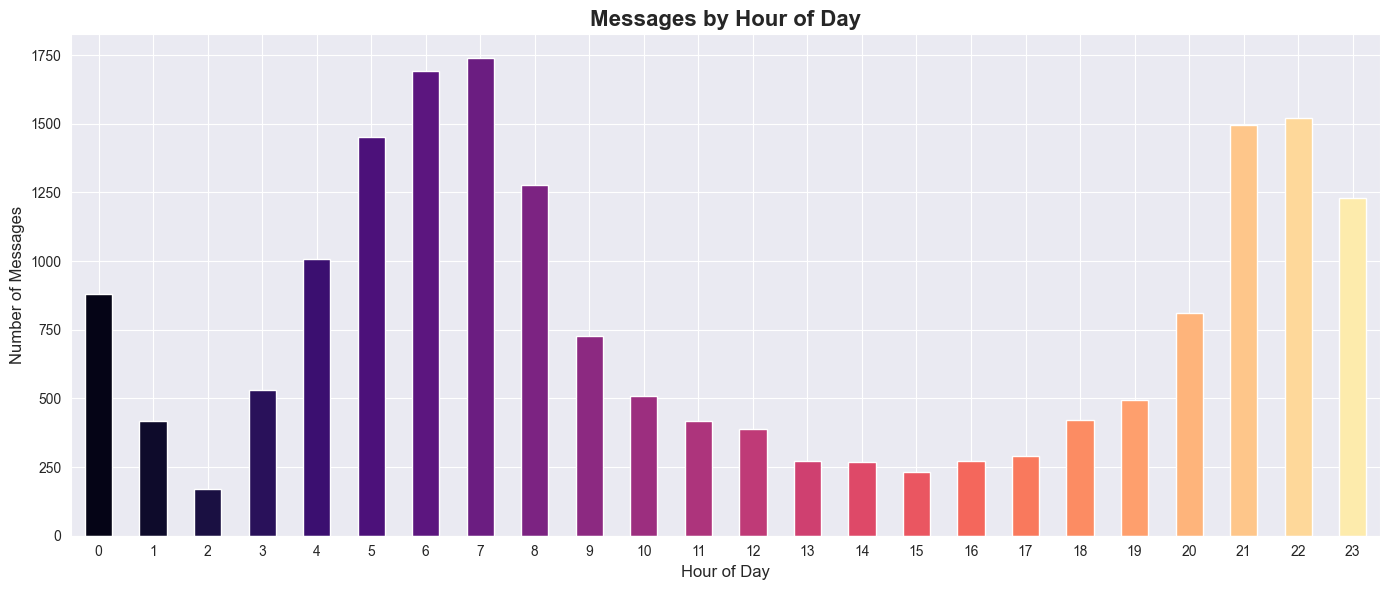

In [13]:
# Messages by hour of day
messages_per_hour = df_filtered.groupby(df_filtered['timestamp'].dt.hour).size()

messages_per_hour.plot(kind='bar', color=sns.color_palette('magma', 24))
plt.title('Messages by Hour of Day', fontsize=16, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Number of Messages', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [14]:
# Message Length Distribution (characters)
message_lengths = df_filtered['message'].str.len()

overall_mean = message_lengths.mean()
overall_median = message_lengths.median()

print(f'\nMessage Length Statistics')
print(f'  Mean: {overall_mean:.2f}')
print(f'  Median: {overall_median:.2f}')


Message Length Statistics
  Mean: 151.39
  Median: 14.00


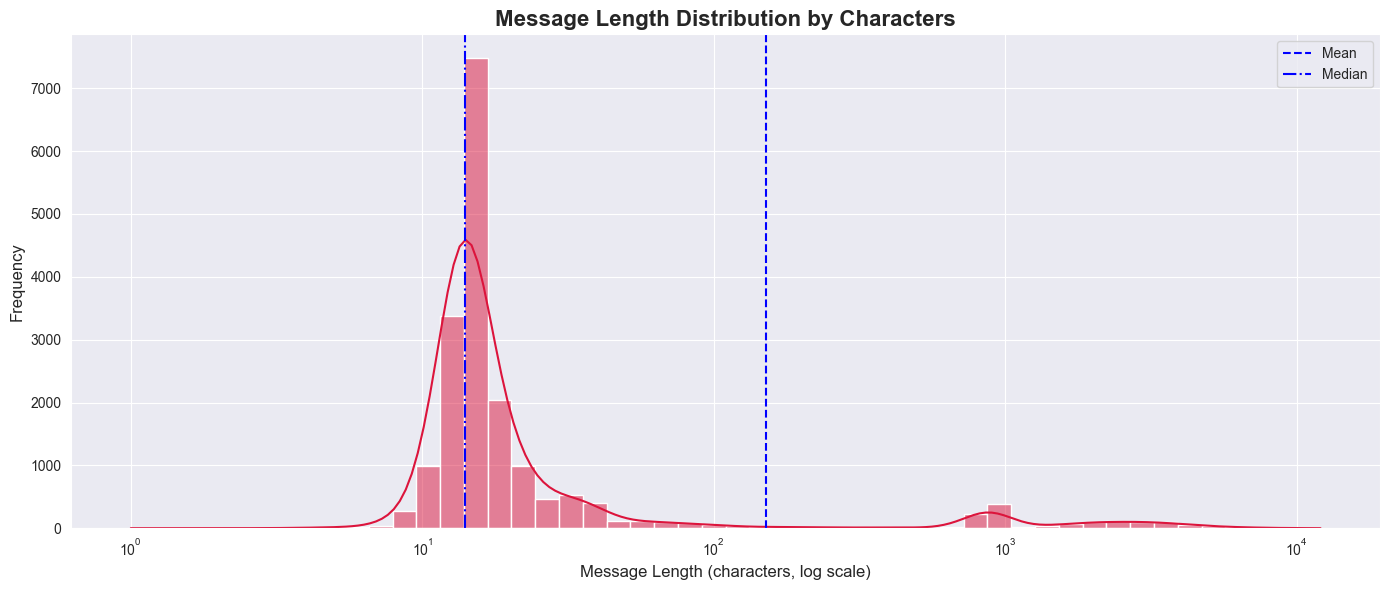

In [15]:
sns.histplot(message_lengths, bins=50, color='crimson', alpha=0.5, kde=True, log_scale=True)

plt.axvline(np.mean(message_lengths), color='blue', linestyle='--', label='Mean')
plt.axvline(np.median(message_lengths), color='blue', linestyle='-.', label='Median')

plt.title('Message Length Distribution by Characters', fontsize=16, fontweight='bold')
plt.xlabel('Message Length (characters, log scale)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Number of lines per message
num_lines = df_filtered['message'].str.count('\n') + 1

overall_lines_mean = num_lines.mean()
overall_lines_median = num_lines.median()

print(f'\nNumber of Lines per Message:')
print(f'  Mean: {overall_lines_mean:.2f}')
print(f'  Median: {overall_lines_median:.2f}')


Number of Lines per Message:
  Mean: 3.98
  Median: 1.00


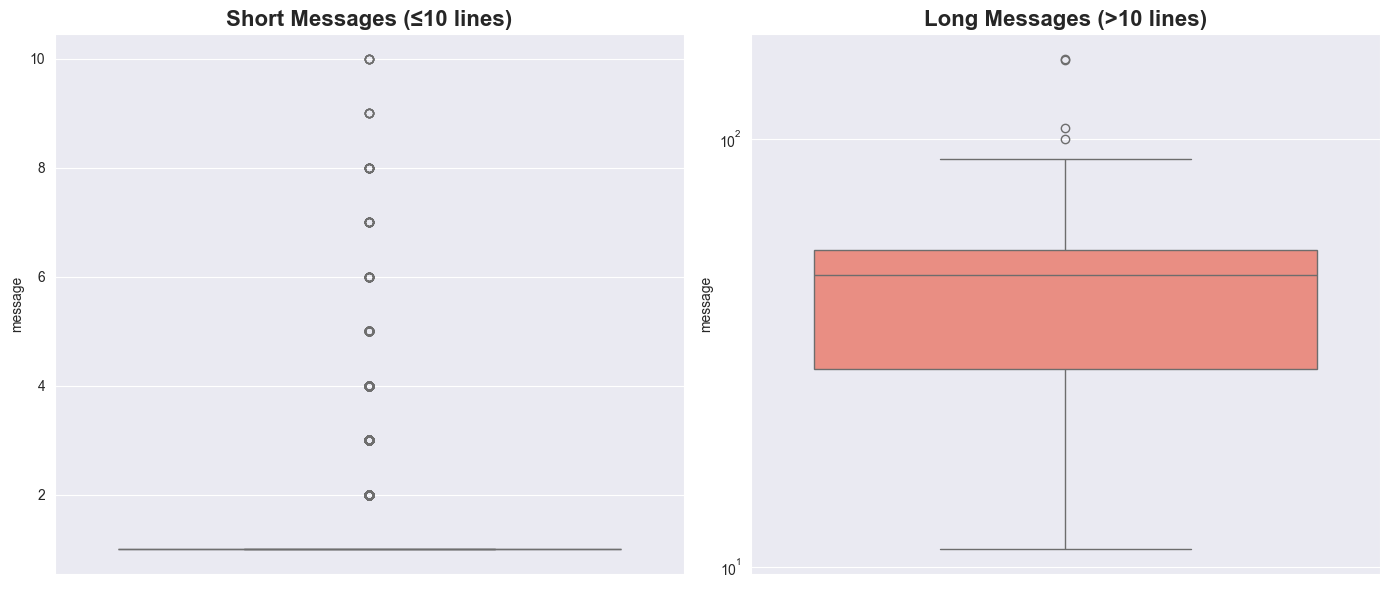

In [17]:
plt.subplot(1, 2, 1)
sns.boxplot(y=num_lines[num_lines <= 10], color='skyblue')
plt.title('Short Messages (≤10 lines)', fontsize=16, fontweight='bold')


plt.subplot(1, 2, 2)
sns.boxplot(y=num_lines[num_lines > 10], color='salmon')
plt.title('Long Messages (>10 lines)', fontsize=16, fontweight='bold')

plt.yscale('log')

plt.tight_layout()
plt.show()

#### 3. Identify Progress Reports

In [18]:
progress_keywords = ['done', 'selesai', 'sudah', 'finish', '✓', '✅', '☑', '💥']

df_clean['has_progress_keyword'] = df_clean['message'].str.lower().apply(
    lambda x: any(kw in x for kw in progress_keywords)
)

print(f'Message with progress keywords')
print(f'Total: {df_clean["has_progress_keyword"].sum()} out of {len(df_clean)} messages')
print(f'Percentage: {df_clean["has_progress_keyword"].sum() / len(df_clean) * 100:.2f}%')

Message with progress keywords
Total: 16200 out of 17191 messages
Percentage: 94.24%


In [19]:
print('\nSample Messages with Progress Keywords:')
df_clean[df_clean['has_progress_keyword']][['sender', 'message']].head(10)


Sample Messages with Progress Keywords:


,sender,message
0,"dr. Andreas C.N., Fp.B.",Siap terimakasih sudah diadd di grup 🙏🏻
25,Melanie Chandra,Kej 1-2 done
26,Lindawati Haryanto,Kej 1-2 done
27,Sherly Cahyadi,Kej 1-2 done
28,Seto Ninik,Kej 1-2 done
29,🪸Martha 🍁,Kej 1-2 done
30,Dewi Pratiwi,Kej 1-2 done
31,Endang Surati,Kej 1- 2 selesai.🙏
32,Dicky Andrian,Kej 1-2 done
33,🎍,Kej 1-2 done


In [20]:
# Extract bible references
import json

with open("../data/bible_references.json", "r", encoding="utf-8") as f:
    bible_books = json.load(f)
    
annotator = BibleReferenceAnnotator(bible_books=bible_books)

df_clean = annotator.annotate_dataframe(df_clean)

print("Messages with Bible References")

total_refs = (df_clean["intent"] == "PROGRESS_REPORT").sum()

print(f"Total: {total_refs}")
print(f"Percentage: {total_refs / len(df_clean) * 100:.2f}%")


Messages with Bible References
Total: 16169
Percentage: 94.06%


In [21]:
progress_df = df_clean[df_clean["intent"] == "PROGRESS_REPORT"]

progress_df.to_csv('../data/processed/progress_report_messages.csv', index=False, encoding="utf-8-sig")

In [22]:
progress_df.shape

(16169, 8)

In [23]:
progress_df.head(15)

,timestamp,sender,message,has_progress_keyword,bible_references,bible_ref_count,intent,ner_spans
19,2020-08-02 21:39:18,Vik. Dessy Waiman,1 Raja dan 2 Raja,False,"[{'book_start': 'dan', 'start_chapter': 2, 'bo...",1,PROGRESS_REPORT,"[{'start': 7, 'end': 10, 'label': 'BOOK', 'tex..."
25,2020-08-03 03:48:55,Melanie Chandra,Kej 1-2 done,True,"[{'book_start': 'Kej', 'start_chapter': 1, 'bo...",2,PROGRESS_REPORT,"[{'start': 0, 'end': 3, 'label': 'BOOK', 'text..."
26,2020-08-03 04:03:51,Lindawati Haryanto,Kej 1-2 done,True,"[{'book_start': 'Kej', 'start_chapter': 1, 'bo...",2,PROGRESS_REPORT,"[{'start': 0, 'end': 3, 'label': 'BOOK', 'text..."
27,2020-08-03 04:08:44,Sherly Cahyadi,Kej 1-2 done,True,"[{'book_start': 'Kej', 'start_chapter': 1, 'bo...",2,PROGRESS_REPORT,"[{'start': 0, 'end': 3, 'label': 'BOOK', 'text..."
28,2020-08-03 04:32:19,Seto Ninik,Kej 1-2 done,True,"[{'book_start': 'Kej', 'start_chapter': 1, 'bo...",2,PROGRESS_REPORT,"[{'start': 0, 'end': 3, 'label': 'BOOK', 'text..."
29,2020-08-03 05:45:14,🪸Martha 🍁,Kej 1-2 done,True,"[{'book_start': 'Kej', 'start_chapter': 1, 'bo...",2,PROGRESS_REPORT,"[{'start': 0, 'end': 3, 'label': 'BOOK', 'text..."
30,2020-08-03 06:07:57,Dewi Pratiwi,Kej 1-2 done,True,"[{'book_start': 'Kej', 'start_chapter': 1, 'bo...",2,PROGRESS_REPORT,"[{'start': 0, 'end': 3, 'label': 'BOOK', 'text..."
31,2020-08-03 06:09:20,Endang Surati,Kej 1- 2 selesai.🙏,True,"[{'book_start': 'Kej', 'start_chapter': 1, 'bo...",2,PROGRESS_REPORT,"[{'start': 0, 'end': 3, 'label': 'BOOK', 'text..."
32,2020-08-03 06:14:01,Dicky Andrian,Kej 1-2 done,True,"[{'book_start': 'Kej', 'start_chapter': 1, 'bo...",2,PROGRESS_REPORT,"[{'start': 0, 'end': 3, 'label': 'BOOK', 'text..."
33,2020-08-03 06:14:26,🎍,Kej 1-2 done,True,"[{'book_start': 'Kej', 'start_chapter': 1, 'bo...",2,PROGRESS_REPORT,"[{'start': 0, 'end': 3, 'label': 'BOOK', 'text..."


In [24]:
other_df =df_clean[df_clean["intent"] != "PROGRESS_REPORT"]

other_df.to_csv('../data/processed/other_messages.csv', index=False, encoding="utf-8-sig")

In [25]:
other_df.shape

(1022, 8)

In [32]:
# Identify likely progress reports 
df_clean['likely_progress'] = (
    df_clean['has_progress_keyword'] & (df_clean['intent'] == "PROGRESS_REPORT")
)

print(f'Likely Progress Reports')
print(f'Total: {df_clean["likely_progress"].sum()}')
print(f'Percentage: {df_clean["likely_progress"].sum() / len(df_clean) * 100:.2f}%')

Likely Progress Reports
Total: 15721
Percentage: 91.45%


In [33]:
# Sample likely progress reports
print('\nSample Likely Progress Reports:')
df_clean[df_clean['likely_progress']][['sender', 'message']].head(15)


Sample Likely Progress Reports:


,sender,message
25,Melanie Chandra,Kej 1-2 done
26,Lindawati Haryanto,Kej 1-2 done
27,Sherly Cahyadi,Kej 1-2 done
28,Seto Ninik,Kej 1-2 done
29,🪸Martha 🍁,Kej 1-2 done
30,Dewi Pratiwi,Kej 1-2 done
31,Endang Surati,Kej 1- 2 selesai.🙏
32,Dicky Andrian,Kej 1-2 done
33,🎍,Kej 1-2 done
34,"dr. Andreas C.N., Sp.B.",Kej 1-2 selesai


#### 4. Pattern Analysis

In [34]:
# Message length analysis 
df_clean['message_length'] = df_clean['message'].str.len()

# Compare length between progress and non-progress messages
progress_lengths = df_clean[df_clean['likely_progress']]['message_length']
non_progress_lengths = df_clean[~df_clean['likely_progress']]['message_length']

print(f'\nMessage Length Statistics')
print(f'\nProgress reports:')
print(f'  Mean: {progress_lengths.mean():.2f}')
print(f'  Median: {progress_lengths.median():.2f}')

print(f'\nNon-Progress reports:')
print(f'  Mean: {non_progress_lengths.mean():.2f}')
print(f'  Median: {non_progress_lengths.median():.2f}')


Message Length Statistics

Progress reports:
  Mean: 17.10
  Median: 14.00

Non-Progress reports:
  Mean: 33.12
  Median: 16.00


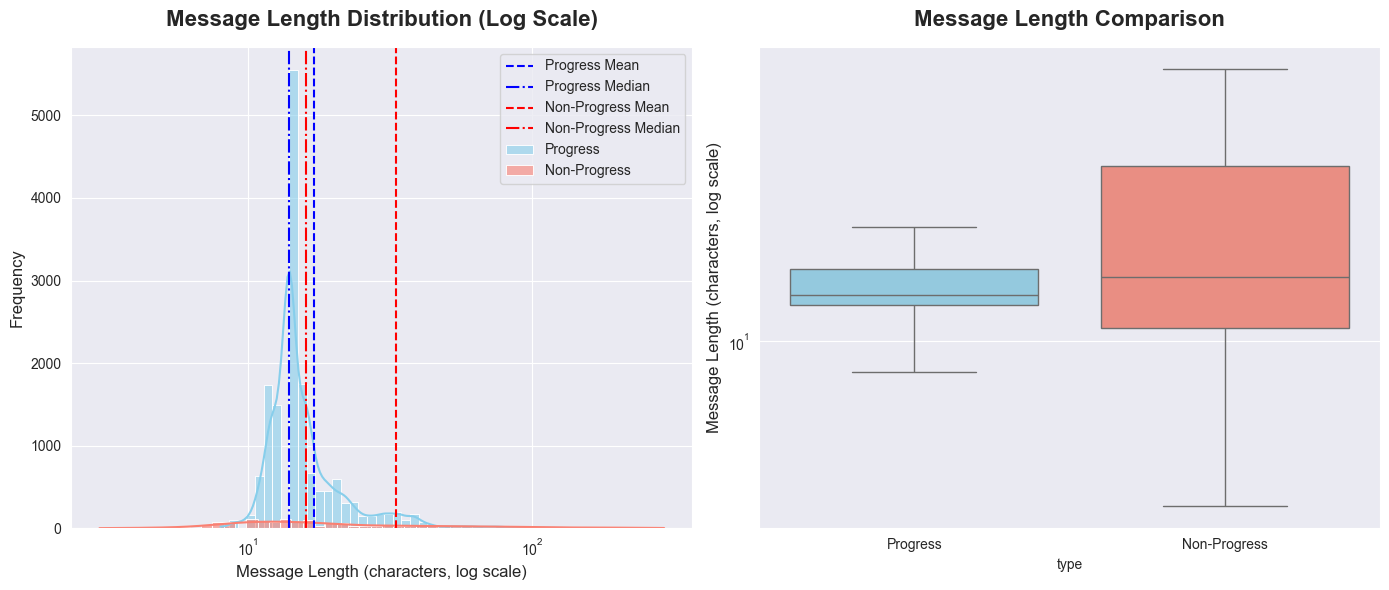

In [35]:

plt.subplot(1, 2, 1)
sns.histplot(progress_lengths, bins=50, color='skyblue', alpha=0.6, label='Progress', kde=True, log_scale=True)
sns.histplot(non_progress_lengths, bins=50, color='salmon',alpha=0.6, label='Non-Progress', kde=True, log_scale=True)

plt.axvline(np.mean(progress_lengths), color='blue', linestyle='--', label='Progress Mean')
plt.axvline(np.median(progress_lengths), color='blue', linestyle='-.', label='Progress Median')

plt.axvline(np.mean(non_progress_lengths), color='red', linestyle='--', label='Non-Progress Mean')
plt.axvline(np.median(non_progress_lengths), color='red', linestyle='-.', label='Non-Progress Median')

plt.title('Message Length Distribution (Log Scale)', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Message Length (characters, log scale)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()

df_box = pd.DataFrame({
    'message_length': np.concatenate([progress_lengths, non_progress_lengths]),
    'type': ['Progress'] * len(progress_lengths) + ['Non-Progress'] * len(non_progress_lengths)
})

plt.subplot(1, 2, 2)
sns.boxplot(data=df_box, x='type', y='message_length', palette={'Progress': 'skyblue', 'Non-Progress': 'salmon'}, showfliers=False)
plt.yscale('log')
plt.xticks([0, 1], ['Progress', 'Non-Progress'])
plt.title('Message Length Comparison', fontsize=16, fontweight='bold', pad=15)
plt.ylabel('Message Length (characters, log scale)', fontsize=12)
plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

In [36]:
# Progress by Members
progress_by_member = df_clean[df_clean['likely_progress']].groupby('sender').size().sort_values(ascending=False)

print(f'Progress Reports by Members (Top 20)')
progress_by_member.head(20)

Progress Reports by Members (Top 20)


sender
Mfitri                      623
Lindawati Haryanto          600
Seto Ninik                  587
Darius Handoko              582
Andrie HG                   581
Ci Ina Paperku              576
susianawati309              564
Ivan teguh                  561
Sim Ay Tjan                 557
Nurcahaya Sihombing         547
🎍                           547
Lenny Pandjidharma          536
Dewi Pratiwi                534
Melanie Chandra             531
Ibu Kartika                 521
Ruri Handoko                493
Kristin WIjaya Nusantara    449
Endang Surati               444
Tjunfebelyana               412
Agnes                       404
dtype: int64

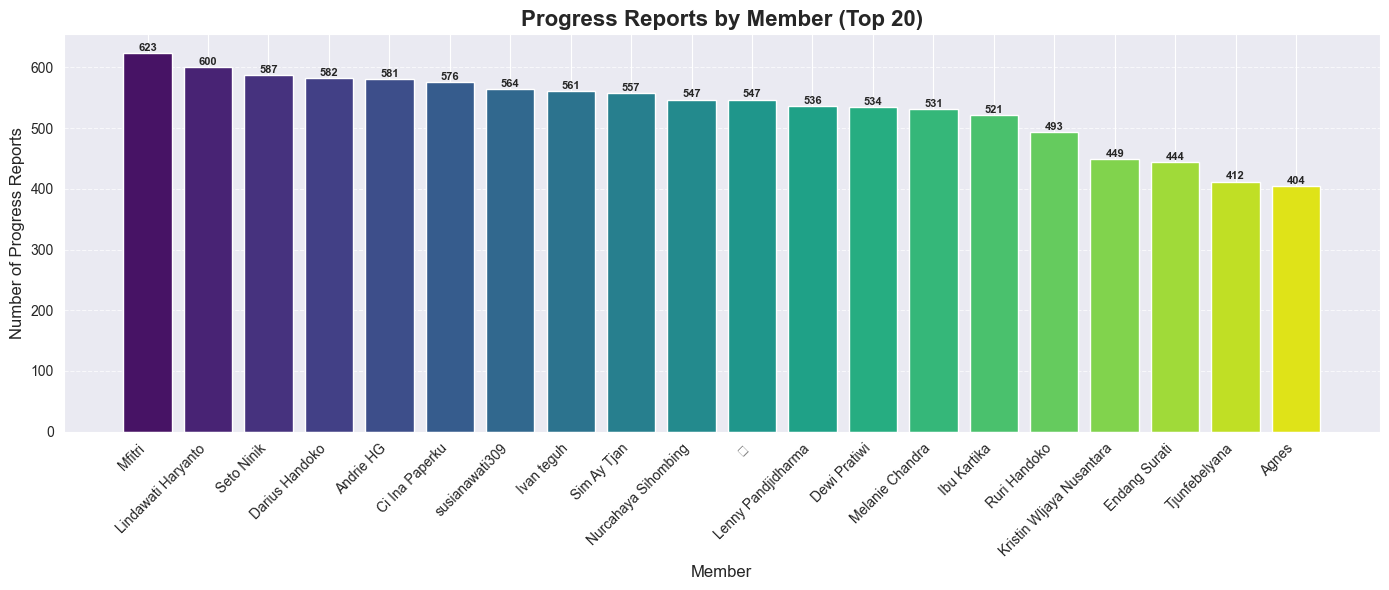

In [37]:
bars = plt.bar(progress_by_member.head(20).index,
               progress_by_member.head(20).values,
               color=sns.color_palette('viridis', 20))

plt.title('Progress Reports by Member (Top 20)', fontsize=16, fontweight='bold')
plt.xlabel('Member', fontsize=12)
plt.ylabel('Number of Progress Reports', fontsize=12)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{int(height)}',
             ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()